# Twitter author prediction

## Prerequisites

### Importing necessary libraries

In [30]:
import random; random.seed(53)
import pandas as pd

# Import all we need from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import itertools


In [31]:
import matplotlib.pyplot as plt
import numpy as np
def plot_and_return_top_features(classifier, vectorizer, top_features=20):
    """
    Plot the top features in a binary classification model and remove possible overlap.

    Adapted from https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
    and https://stackoverflow.com/a/26980472 by @kjam
    """
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names_out()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:top_features]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-top_features:]
    top_coefficients = np.hstack([topn_class1, topn_class2])
    if set(topn_class1).union(topn_class2):
        top_coefficients = topn_class1
        for ce in topn_class2:
            if ce not in topn_class1:
                top_coefficients.append(ce)

    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in [tc[0] for tc in top_coefficients]]
    plt.bar(np.arange(len(top_coefficients)), [tc[0] for tc in top_coefficients], color=colors)
    plt.xticks(np.arange(len(top_coefficients)),
               [tc[1] for tc in top_coefficients], rotation=60, ha='right')
    plt.show()
    return top_coefficients

In [32]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figure=0):
    """
    See full source and example:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figure)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



### Load the data

In [33]:
# Load data
tweet_df = pd.read_csv("C:/Users/Oliver/Documents/BCE/Tárgyak/9. félév/Többváltozós statisztika/tweets.csv")

In [34]:
# Create target
y = tweet_df["author"]
# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(tweet_df["status"], y,  test_size=0.2, stratify=y, random_state=42)

## Data cleaning

### CountVectorizer

In [35]:
count_vectorizer = CountVectorizer(stop_words="english", min_df=0.05, max_df=0.9)
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

### Tf-Idf

In [36]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english", min_df=0.05, max_df=0.9)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

## Training the models

### Training a multinomial naive Bayes model

In [37]:
# Create and fit the model for the tf-idf data
param_grid_nb = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
    'fit_prior': [True, False],
}
tf_idf_nb_cv = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5)
tf_idf_nb_cv.fit(tfidf_train, y_train)
tf_idf_nb = tf_idf_nb_cv.best_estimator_
tf_idf_nb_pred = tf_idf_nb.predict(tfidf_test)
print("Best parameters: {}".format(tf_idf_nb_cv.best_params_))

# Create and fit the model for the count data

count_nb = MultinomialNB()

count_nb.fit(count_train, y_train)
count_nb_pred = count_nb.predict(count_test)

Best parameters: {'alpha': 0.0001, 'fit_prior': True}


### Training an SVM model

In [38]:
param_grid_svc = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "dual": [True, False],
}
tf_idf_svc_cv = GridSearchCV(LinearSVC(), param_grid=param_grid_svc, cv=5)
tf_idf_svc_cv.fit(tfidf_train, y_train)
tf_idf_svc_pred = tf_idf_svc_cv.predict(tfidf_test)
tf_idf_svc = tf_idf_svc_cv.best_estimator_
print("Best parameters: {}".format(tf_idf_svc_cv.best_params_))

Best parameters: {'C': 10, 'dual': True}


### Training a logistic regression model

In [39]:
param_grid_lr = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10]
}
tf_idf_lr_cv = GridSearchCV(LogisticRegression(), param_grid=param_grid_lr, cv=5)
tf_idf_lr_cv.fit(tfidf_train, y_train)
tf_idf_lr = tf_idf_lr_cv.best_estimator_
tf_idf_lr_pred = tf_idf_lr.predict(tfidf_test)
print("Best parameters: {}".format(tf_idf_lr_cv.best_params_))

Best parameters: {'C': 10}


### Training a decision tree model

In [40]:
param_grid_dt = {
    "criterion": ["gini", "entropy"],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8]
}
tf_idf_dt_cv = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid_dt, cv=5)
tf_idf_dt_cv.fit(tfidf_train, y_train)
tf_idf_dt = tf_idf_dt_cv.best_estimator_
tf_idf_dt_pred = tf_idf_dt.predict(tfidf_test)
print("Best parameters: {}".format(tf_idf_dt_cv.best_params_))

Best parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 7}


### Training a random forest model

In [41]:
tf_idf_rf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, max_samples=0.8, max_features=0.8, random_state=42, n_jobs=-1)
tf_idf_rf.fit(tfidf_train, y_train)
tf_idf_rf_pred = tf_idf_rf.predict(tfidf_test)

## Accuracy scores (for the tf-idf vectorizer)

In [42]:
target_values = list(tf_idf_lr.classes_)
target_values

['Donald J. Trump', 'Justin Trudeau']

### Confusion matrices

In [43]:
tf_idf_nb_cm = metrics.confusion_matrix(y_test, tf_idf_nb_pred, labels=target_values, normalize='true')
tf_idf_svc_cm = metrics.confusion_matrix(y_test, tf_idf_svc_pred, labels=target_values, normalize='true')
tf_idf_lr_cm = metrics.confusion_matrix(y_test, tf_idf_lr_pred, labels=target_values, normalize='true')
tf_idf_dt_cm = metrics.confusion_matrix(y_test, tf_idf_dt_pred, labels=target_values, normalize='true')
tf_idf_rf_cm = metrics.confusion_matrix(y_test, tf_idf_rf_pred, labels=target_values, normalize='true')

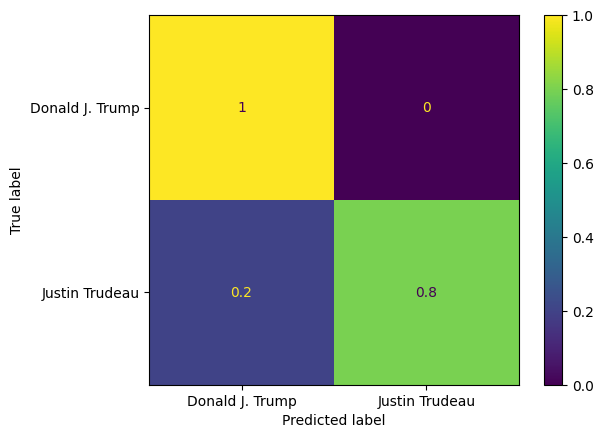

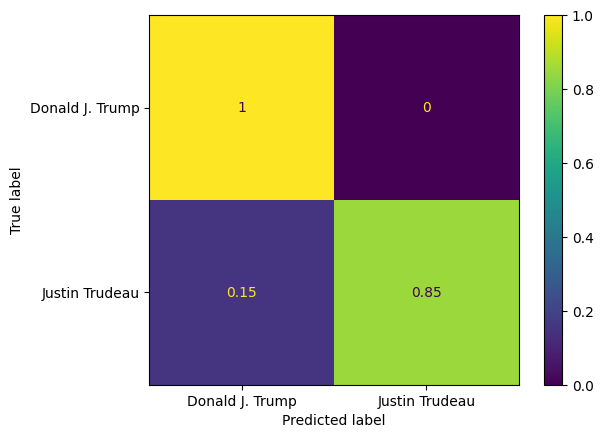

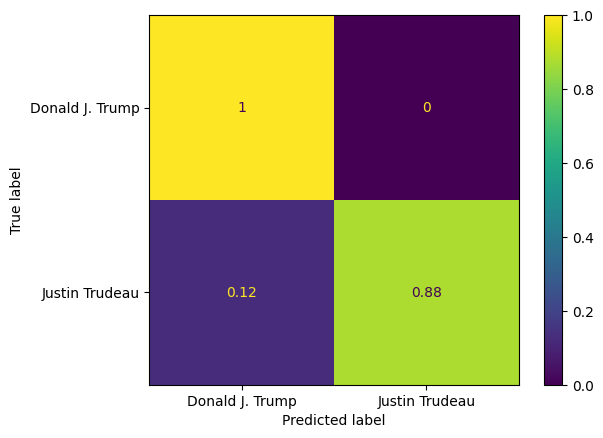

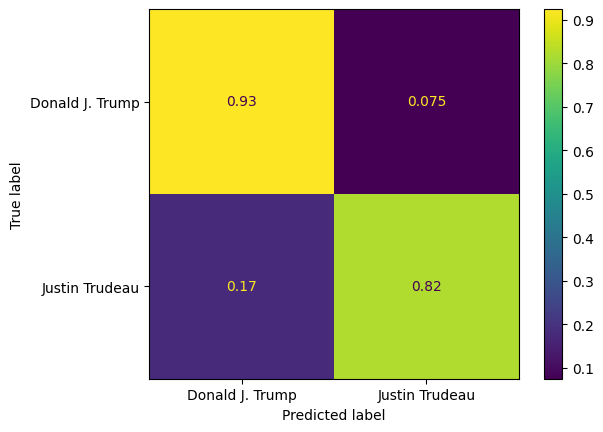

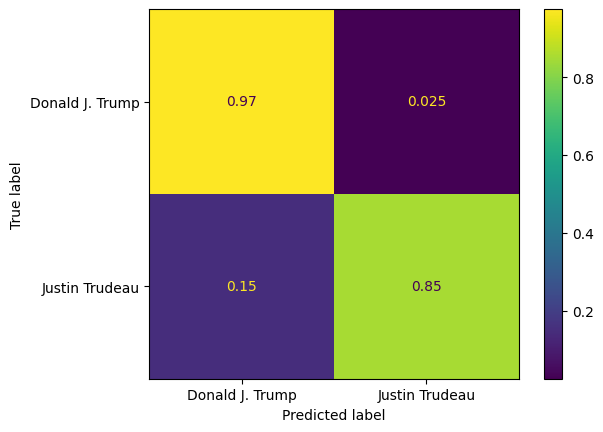

In [44]:
metrics.ConfusionMatrixDisplay(tf_idf_nb_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_svc_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_lr_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_dt_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_rf_cm, display_labels=target_values).plot()

In [45]:
tf_idf_nb_cm = metrics.confusion_matrix(y_test, tf_idf_nb_pred, labels=target_values)
tf_idf_svc_cm = metrics.confusion_matrix(y_test, tf_idf_svc_pred, labels=target_values)
tf_idf_lr_cm = metrics.confusion_matrix(y_test, tf_idf_lr_pred, labels=target_values)
tf_idf_dt_cm = metrics.confusion_matrix(y_test, tf_idf_dt_pred, labels=target_values)
tf_idf_rf_cm = metrics.confusion_matrix(y_test, tf_idf_rf_pred, labels=target_values)

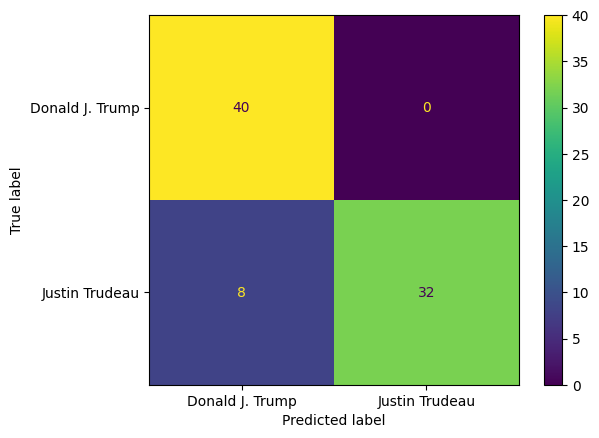

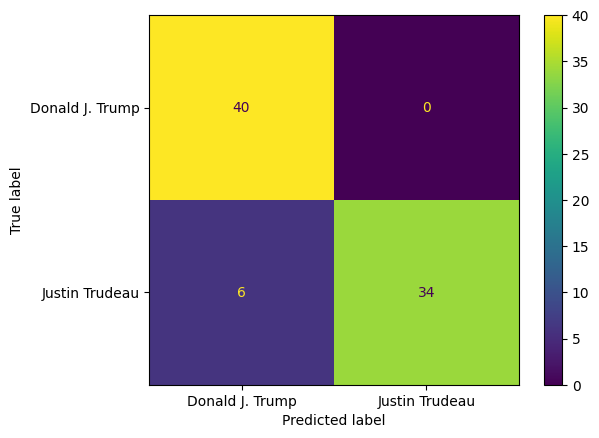

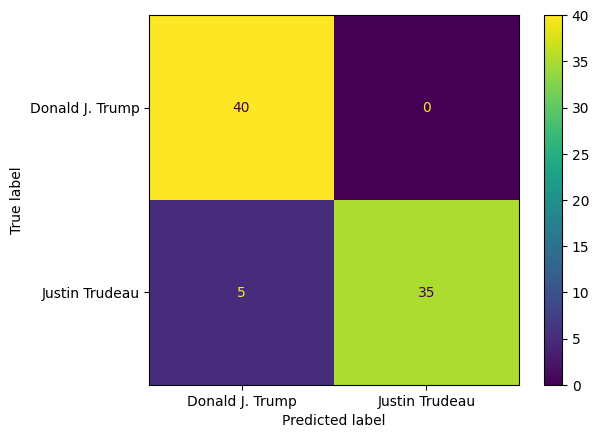

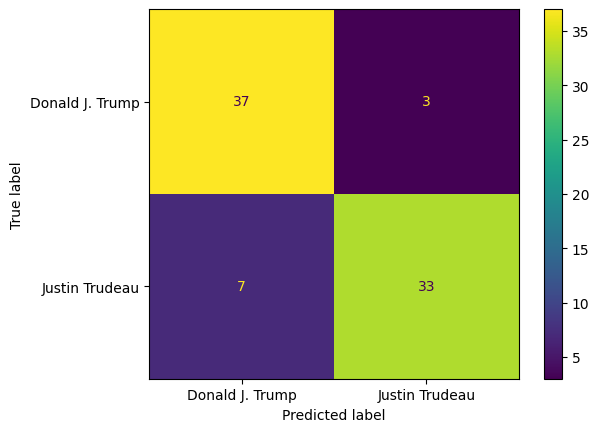

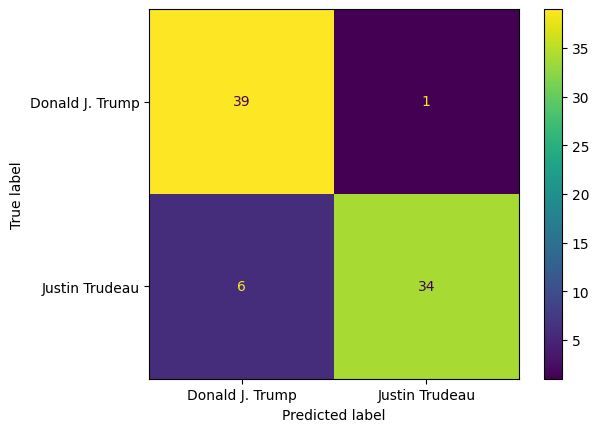

In [46]:
metrics.ConfusionMatrixDisplay(tf_idf_nb_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_svc_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_lr_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_dt_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_rf_cm, display_labels=target_values).plot()

### Accuracy scores of the models (on the test set)

In [47]:
print("Naive Bayes\t\t", tf_idf_nb.score(tfidf_test, y_test))
print("SVC\t\t\t", tf_idf_svc.score(tfidf_test, y_test))
print("Logistic Regression\t", tf_idf_lr.score(tfidf_test, y_test))
print("Decision Tree\t\t", tf_idf_dt.score(tfidf_test, y_test))
print("Random Forest\t\t", tf_idf_rf.score(tfidf_test, y_test))

Naive Bayes		 0.9
SVC			 0.925
Logistic Regression	 0.9375
Decision Tree		 0.875
Random Forest		 0.9125


### Cross-validation (on the training set)

In [48]:
print(f"Naive Bayes:\t\t{tf_idf_nb_cv.best_score_}")
print(f"SVC:\t\t\t{tf_idf_svc_cv.best_score_}")
print(f"Logistic Regression:\t{tf_idf_lr_cv.best_score_}")
print(f"Decision Tree:\t\t{tf_idf_dt_cv.best_score_}")
print(f"Random Forest:\t\tNo cross validation performed") # BaggingClassifier does not support cross validation

Naive Bayes:		0.821875
SVC:			0.825
Logistic Regression:	0.81875
Decision Tree:		0.821875
Random Forest:		No cross validation performed


### Recall scores of the models

In [49]:
print("Naive Bayes".ljust(20), metrics.recall_score(y_test, tf_idf_nb_pred, labels=target_values, pos_label=target_values[0]))
print("SVC".ljust(20), metrics.recall_score(y_test, tf_idf_svc_pred, labels=target_values, pos_label=target_values[0]))
print("Logistic Regression".ljust(20), metrics.recall_score(y_test, tf_idf_lr_pred, labels=target_values, pos_label=target_values[0]))
print("Decision Tree".ljust(20), metrics.recall_score(y_test, tf_idf_dt_pred, labels=target_values, pos_label=target_values[0]))
print("Random Forest".ljust(20), metrics.recall_score(y_test, tf_idf_rf_pred, labels=target_values, pos_label=target_values[0]))

Naive Bayes          1.0
SVC                  1.0
Logistic Regression  1.0
Decision Tree        0.925
Random Forest        0.975


### Precision scores of the models

In [50]:
print("Naive Bayes".ljust(20), metrics.precision_score(y_test, tf_idf_nb_pred, labels=target_values, pos_label=target_values[0]))
print("SVC".ljust(20), metrics.precision_score(y_test, tf_idf_svc_pred, labels=target_values, pos_label=target_values[0]))
print("Logistic Regression".ljust(20), metrics.precision_score(y_test, tf_idf_lr_pred, labels=target_values, pos_label=target_values[0]))
print("Decision Tree".ljust(20), metrics.precision_score(y_test, tf_idf_dt_pred, labels=target_values, pos_label=target_values[0]))
print("Random Forest".ljust(20), metrics.precision_score(y_test, tf_idf_rf_pred, labels=target_values, pos_label=target_values[0]))

Naive Bayes          0.8333333333333334
SVC                  0.8695652173913043
Logistic Regression  0.8888888888888888
Decision Tree        0.8409090909090909
Random Forest        0.8666666666666667


### f1-scores of the models

In [51]:
print("Naive Bayes".ljust(20), metrics.f1_score(y_test, tf_idf_nb_pred, labels=target_values, pos_label=target_values[0]))
print("SVC".ljust(20), metrics.f1_score(y_test, tf_idf_svc_pred, labels=target_values, pos_label=target_values[0]))
print("Logistic Regression".ljust(20), metrics.f1_score(y_test, tf_idf_lr_pred, labels=target_values, pos_label=target_values[0]))
print("Decision Tree".ljust(20), metrics.f1_score(y_test, tf_idf_dt_pred, labels=target_values, pos_label=target_values[0]))
print("Random Forest".ljust(20), metrics.f1_score(y_test, tf_idf_rf_pred, labels=target_values, pos_label=target_values[0]))

Naive Bayes          0.9090909090909091
SVC                  0.9302325581395349
Logistic Regression  0.9411764705882353
Decision Tree        0.8809523809523809
Random Forest        0.9176470588235294


### Classification reports

In [52]:
# classification report
report_nb = metrics.classification_report(y_test, tf_idf_nb_pred, labels=target_values, output_dict=True)
report_svm = metrics.classification_report(y_test, tf_idf_svc_pred, labels=target_values, output_dict=True)
report_lr = metrics.classification_report(y_test, tf_idf_lr_pred, labels=target_values, output_dict=True)
report_dt = metrics.classification_report(y_test, tf_idf_dt_pred, labels=target_values, output_dict=True)
report_rf = metrics.classification_report(y_test, tf_idf_rf_pred, labels=target_values, output_dict=True)


df_nb = pd.DataFrame.from_dict(report_nb).transpose()
df_svm = pd.DataFrame.from_dict(report_svm).transpose()
df_lr = pd.DataFrame.from_dict(report_lr).transpose()
df_dt = pd.DataFrame.from_dict(report_dt).transpose()
df_rf = pd.DataFrame.from_dict(report_rf).transpose()

report_dict = {
    "Naive Bayes": df_nb,
    "SVM": df_svm,
    "Logistic Regression": df_lr,
    "Decision Tree": df_dt,
    "Random Forest": df_rf
}

for model, report in report_dict.items():
    print(model)
    print(report)
    print("\n")

Naive Bayes
                 precision  recall  f1-score  support
Donald J. Trump   0.833333     1.0  0.909091     40.0
Justin Trudeau    1.000000     0.8  0.888889     40.0
accuracy          0.900000     0.9  0.900000      0.9
macro avg         0.916667     0.9  0.898990     80.0
weighted avg      0.916667     0.9  0.898990     80.0


SVM
                 precision  recall  f1-score  support
Donald J. Trump   0.869565   1.000  0.930233   40.000
Justin Trudeau    1.000000   0.850  0.918919   40.000
accuracy          0.925000   0.925  0.925000    0.925
macro avg         0.934783   0.925  0.924576   80.000
weighted avg      0.934783   0.925  0.924576   80.000


Logistic Regression
                 precision  recall  f1-score  support
Donald J. Trump   0.888889  1.0000  0.941176  40.0000
Justin Trudeau    1.000000  0.8750  0.933333  40.0000
accuracy          0.937500  0.9375  0.937500   0.9375
macro avg         0.944444  0.9375  0.937255  80.0000
weighted avg      0.944444  0.9375  0.9372

### Roc-auc scores of the models

In [53]:
print("Naive Bayes".ljust(20), metrics.roc_auc_score(y_test, tf_idf_nb.predict_proba(tfidf_test)[:,1]))
print("SVC does not support predict_proba")
print("Logistic Regression".ljust(20), metrics.roc_auc_score(y_test, tf_idf_lr.predict_proba(tfidf_test)[:,1]))
print("Decision Tree".ljust(20), metrics.roc_auc_score(y_test, tf_idf_dt.predict_proba(tfidf_test)[:,1]))
print("Random Forest".ljust(20), metrics.roc_auc_score(y_test, tf_idf_rf.predict_proba(tfidf_test)[:,1]))

Naive Bayes          0.925
SVC does not support predict_proba
Logistic Regression  0.98125
Decision Tree        0.9196875
Random Forest        0.963125
